# Simple Microscope Simulation

This notebook demonstrates the individual components of a simple microscope model, then combines them into a complete simulation using the `simple_microscope` function. 

## Overview

A simple microscope forward model consists of the following elements:
1. **Sample** - A USAF 1951 resolution test pattern
2. **Linear Interaction** - Light interacts with the sample
3. **Optical Zoom** - Magnification by the objective lens
4. **Circular Aperture** - Limits the numerical aperture
5. **Fraunhofer Propagation** - Far-field propagation to the camera

## Imports

In [1]:
import janssen as jns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as cmo
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle

In [2]:
jns.__version__

'2025.10.4'

In [3]:
%load_ext autoreload
%autoreload 2

## Define Simulation Parameters

We create a sample that is:
- 2.5 mm x 2.5 mm in physical size
- 0.5 micron pixel size
- This gives us 5000 x 5000 pixels

In [4]:
pixel_size = 0.5e-6  # 0.5 microns
num_pixels = 4096
wavelength = 633e-9  # 633 nm (HeNe laser)
sample_size = pixel_size * num_pixels  # 2.5 mm

print(f"Pixel size: {pixel_size * 1e6:.1f} microns")
print(f"Number of pixels: {num_pixels} x {num_pixels}")
print(f"Sample size: {sample_size * 1e3:.2f} mm")
print(f"Wavelength: {wavelength * 1e9:.0f} nm")

Pixel size: 0.5 microns
Number of pixels: 4096 x 4096
Sample size: 2.05 mm
Wavelength: 633 nm


## 1. Create USAF 1951 Test Pattern Sample

The USAF 1951 resolution test chart is a standard for measuring optical resolution. It consists of groups of bar patterns at different sizes.

In [5]:
usaf_sample = jns.models.generate_usaf_pattern(
    image_size=num_pixels,
    auto=True,
    pixel_size=pixel_size,
    max_phase=jnp.pi,
)

print(f"Sample shape: {usaf_sample.sample.shape}")
print(f"Sample dx: {usaf_sample.dx * 1e6:.2f} microns")

Sample shape: (4096, 4096)
Sample dx: 0.50 microns


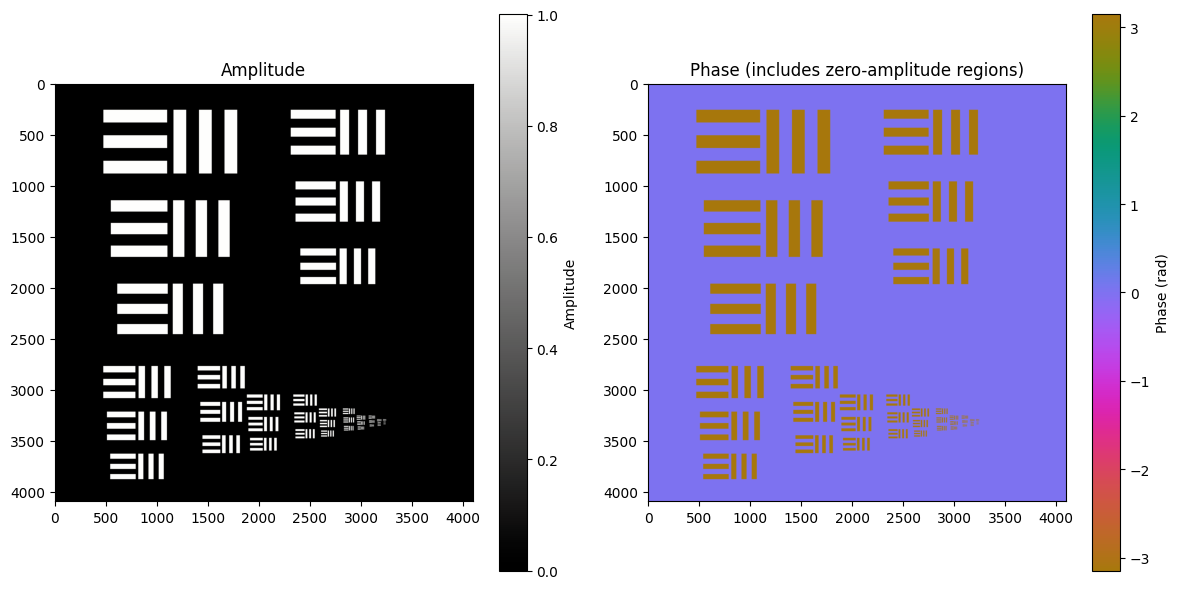

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

amp = jnp.abs(usaf_sample.sample)
phase = jnp.angle(usaf_sample.sample)

# Amplitude
im0 = axes[0].imshow(amp, cmap=cmo.gray)
axes[0].set_title('Amplitude')
plt.colorbar(im0, ax=axes[0], label='Amplitude')

# Phase (circular colormap - ideal for phase wrapping)
im1 = axes[1].imshow(phase, cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[1].set_title('Phase (includes zero-amplitude regions)')
plt.colorbar(im1, ax=axes[1], label='Phase (rad)')

plt.tight_layout()
plt.show()

## 2. Create Illumination Wavefront

We create a collimated (plane wave) illumination to interact with the sample.

In [7]:
illumination_size = 1024

lightwave = jns.models.plane_wave(
    wavelength=wavelength,
    dx=pixel_size,
    grid_size=(illumination_size, illumination_size),
    amplitude=1.0,
)

print(f"Illumination field shape: {lightwave.field.shape}")
print(f"Illumination wavelength: {lightwave.wavelength * 1e9:.0f} nm")
print(f"Illumination dx: {lightwave.dx * 1e6:.2f} microns")

Illumination field shape: (1024, 1024)
Illumination wavelength: 633 nm
Illumination dx: 0.50 microns


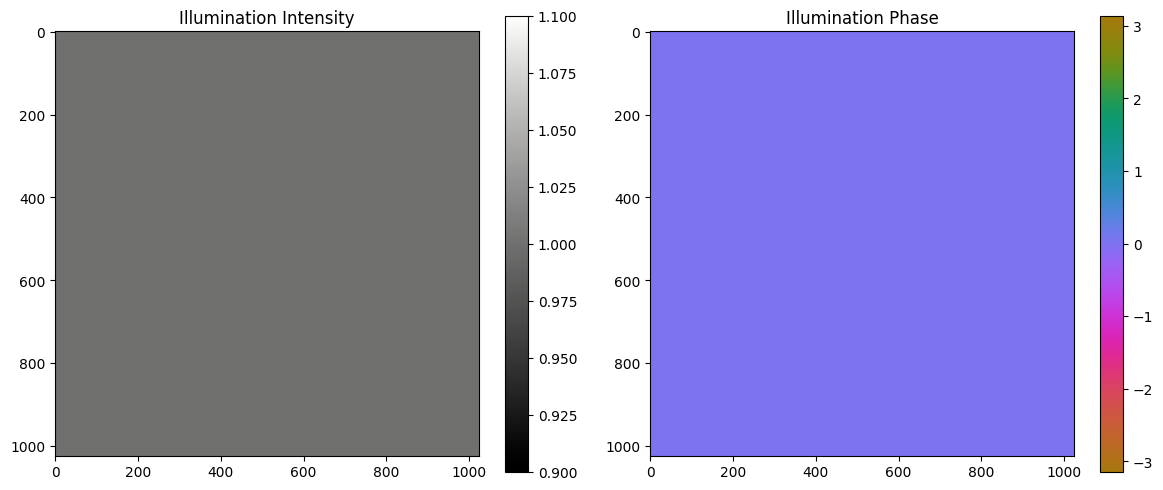

In [8]:
# Visualize the illumination
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(lightwave.field)**2, cmap=cmo.gray)
axes[0].set_title('Illumination Intensity')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.angle(lightwave.field), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[1].set_title('Illumination Phase')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 3. Linear Interaction - Light Through Sample

The `linear_interaction` function models how light passes through a sample. The sample is treated as a complex transmission function that multiplies the incoming wavefront.

In [9]:
num_pixels

4096

Sample region shape: (1024, 1024)


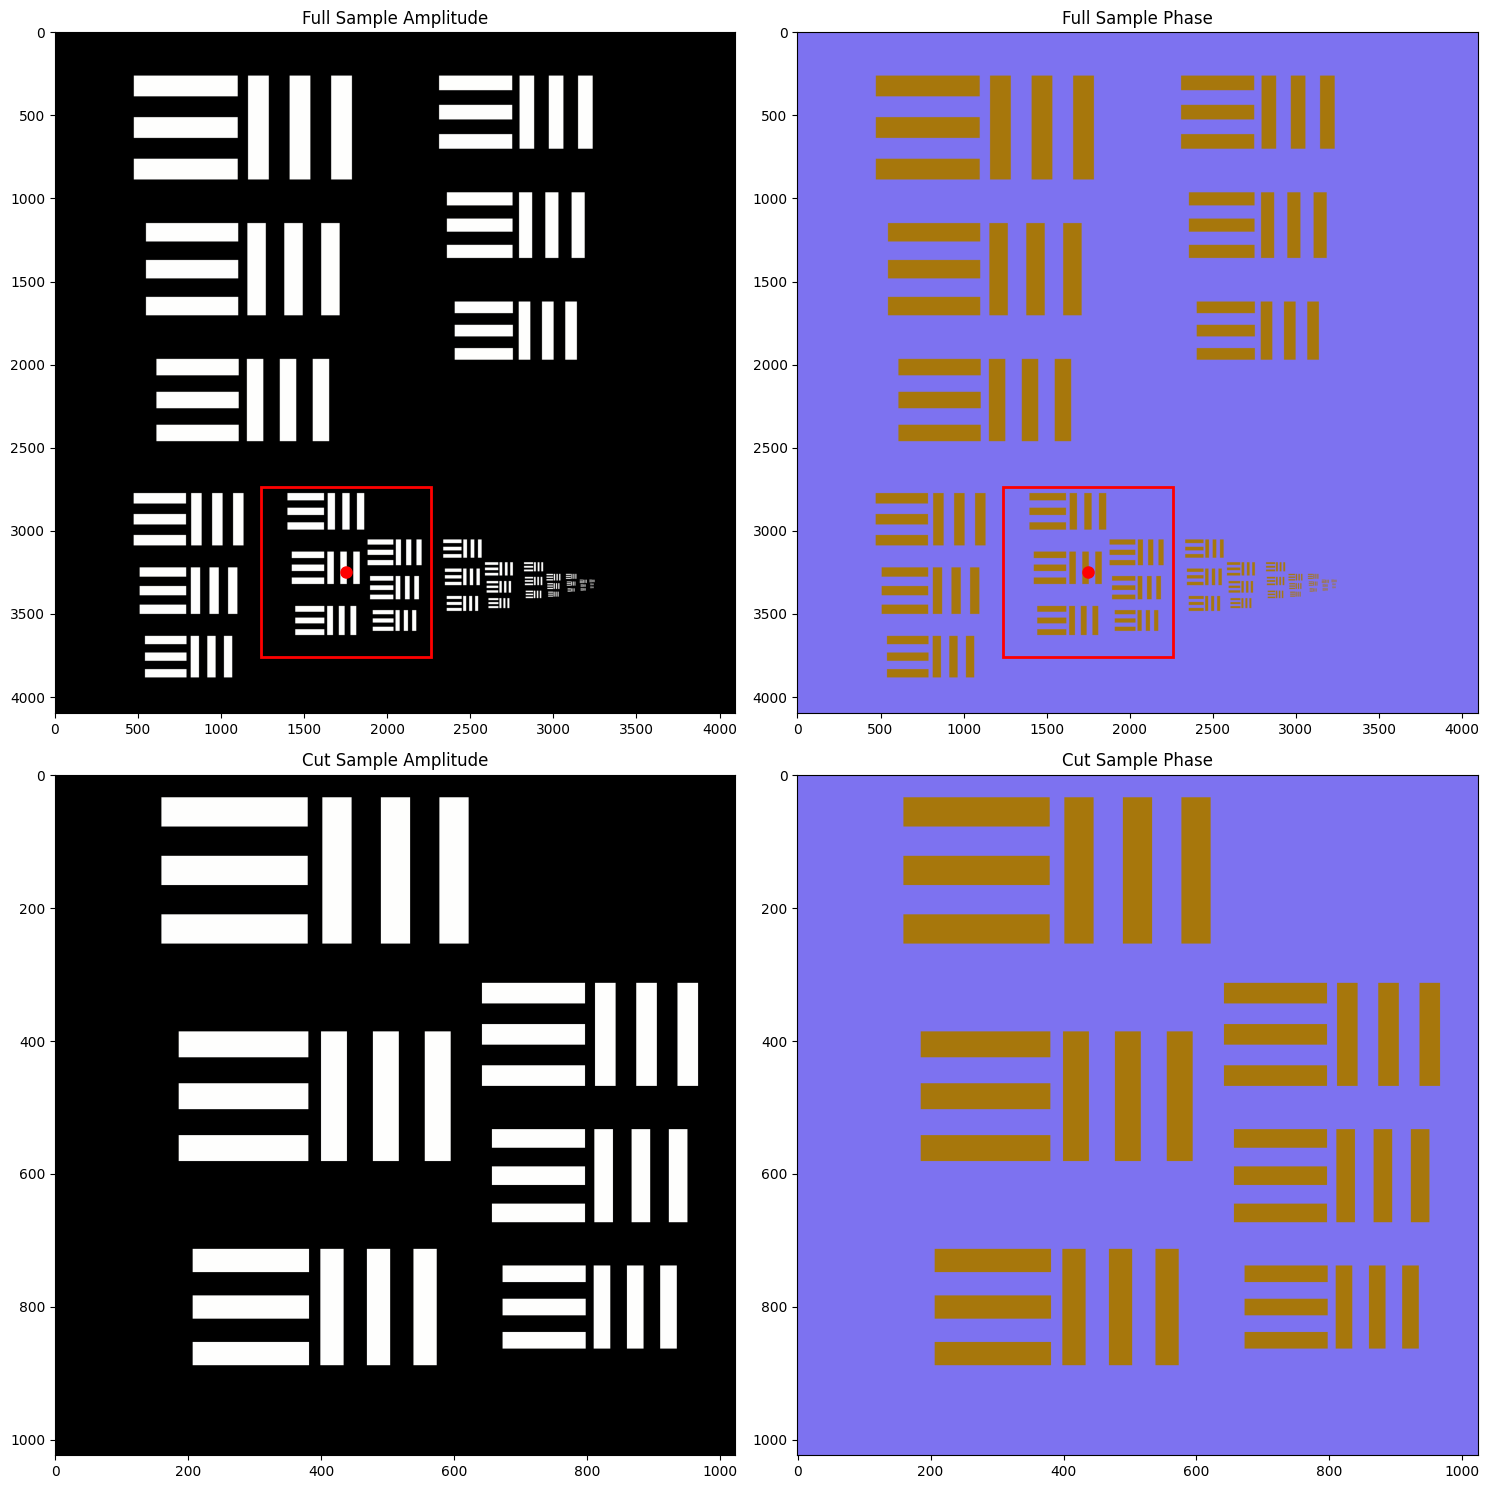

In [10]:
center = (3250, 1750)
half_size = illumination_size // 2
sample_cut = usaf_sample.sample[
    center[0] - half_size : center[0] + half_size,
    center[1] - half_size : center[1] + half_size
]

sample_region = jns.utils.make_sample_function(
    sample=sample_cut,
    dx=pixel_size,
)

print(f"Sample region shape: {sample_region.sample.shape}")

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

im00 = axes[0, 0].imshow(jnp.abs(usaf_sample.sample), cmap=cmo.gray)
axes[0, 0].set_title('Full Sample Amplitude')

# Add red box showing where the cut sample comes from
# center is (y, x) tuple, Rectangle takes (x, y) for bottom-left corner
center_y, center_x = center
box_x = center_x - half_size
box_y = center_y - half_size
rect = Rectangle((box_x, box_y), illumination_size, illumination_size,
                 linewidth=2, edgecolor='red', facecolor='none')
axes[0, 0].add_patch(rect)
# Add center dot (plot takes x, y order)
axes[0, 0].plot(center_x, center_y, 'ro', markersize=8)

im01 = axes[0, 1].imshow(jnp.angle(usaf_sample.sample), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[0, 1].set_title('Full Sample Phase')

# Add matching box and dot to phase image
rect2 = Rectangle((box_x, box_y), illumination_size, illumination_size,
                  linewidth=2, edgecolor='red', facecolor='none')
axes[0, 1].add_patch(rect2)
axes[0, 1].plot(center_x, center_y, 'ro', markersize=8)

im10 = axes[1, 0].imshow(jnp.abs(sample_region.sample), cmap=cmo.gray)
axes[1, 0].set_title('Cut Sample Amplitude')

im11 = axes[1, 1].imshow(jnp.angle(sample_region.sample), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[1, 1].set_title('Cut Sample Phase')

plt.tight_layout()
plt.show()

In [11]:
# Apply linear interaction
after_sample = jns.scopes.linear_interaction(
    sample=sample_region,
    light=lightwave,
)

print(f"After sample field shape: {after_sample.field.shape}")
print(f"After sample dx: {after_sample.dx * 1e6:.2f} microns")

After sample field shape: (1024, 1024)
After sample dx: 0.50 microns


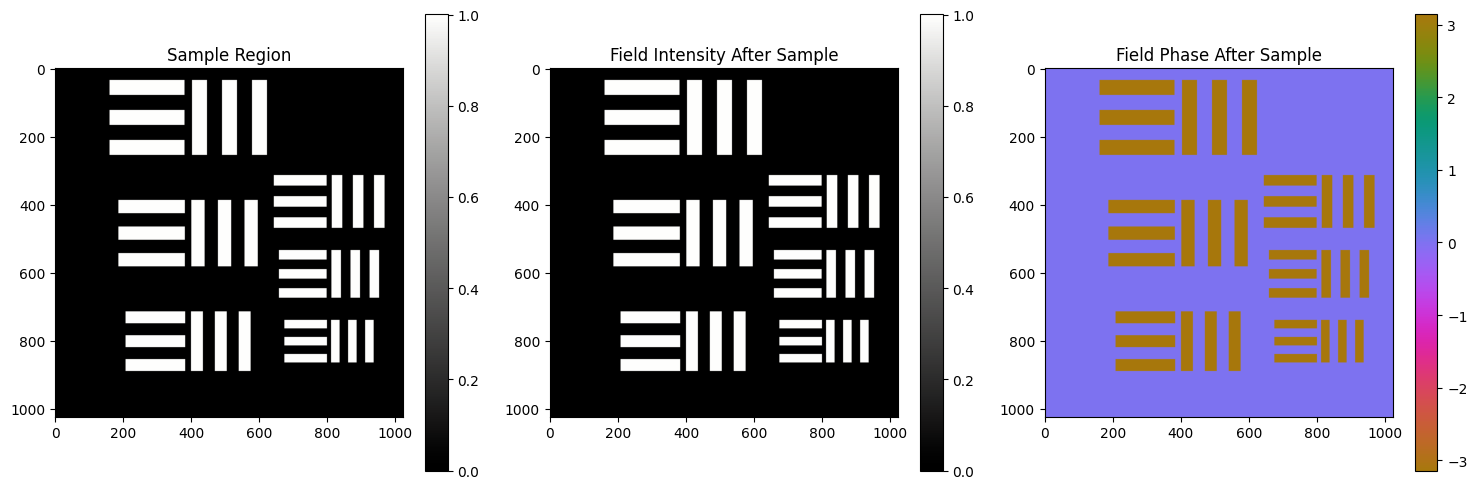

In [12]:
# Visualize the field after interacting with the sample
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(jnp.abs(sample_region.sample), cmap=cmo.gray)
axes[0].set_title('Sample Region')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(after_sample.field)**2, cmap=cmo.gray)
axes[1].set_title('Field Intensity After Sample')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(jnp.angle(after_sample.field), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[2].set_title('Field Phase After Sample')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

## 4. Optical Zoom - Magnification

The `optical_zoom` function models the magnification from the objective lens. It scales the pixel size (dx) by the zoom factor while keeping the array size constant.

In [13]:
# Apply optical zoom (magnification)
zoom_factor = 10.0  # 10x magnification

zoomed_wave = jns.prop.optical_zoom(after_sample, zoom_factor)

print(f"Before zoom dx: {after_sample.dx * 1e6:.2f} microns")
print(f"After zoom dx: {zoomed_wave.dx * 1e6:.2f} microns")
print(f"Magnification achieved: {zoomed_wave.dx / after_sample.dx:.1f}x")

Before zoom dx: 0.50 microns
After zoom dx: 5.00 microns
Magnification achieved: 10.0x


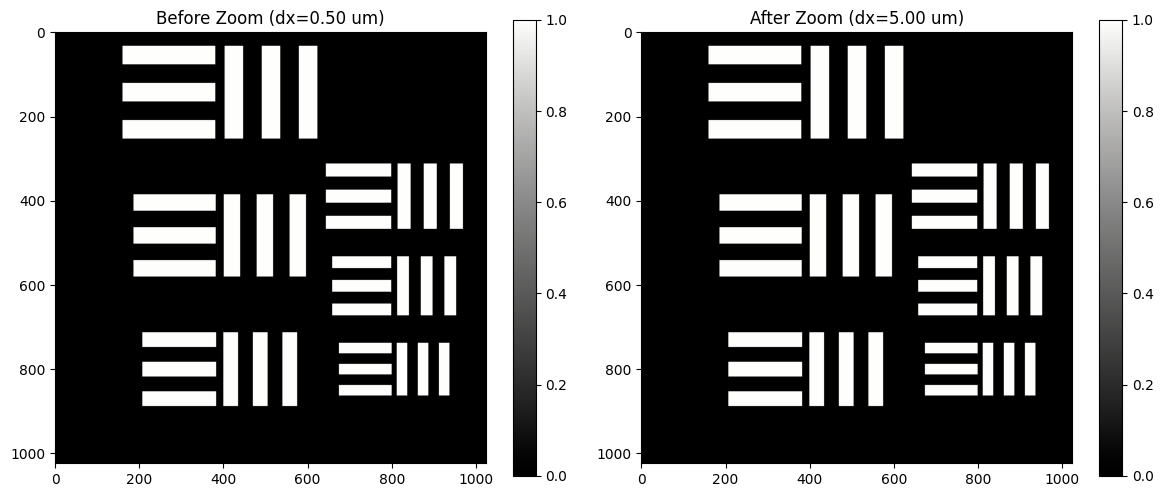

In [14]:
# Visualize the zoomed field
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(after_sample.field)**2, cmap=cmo.gray)
axes[0].set_title(f'Before Zoom (dx={after_sample.dx*1e6:.2f} um)')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(zoomed_wave.field)**2, cmap=cmo.gray)
axes[1].set_title(f'After Zoom (dx={zoomed_wave.dx*1e6:.2f} um)')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 5. Circular Aperture - Numerical Aperture Limit

The `circular_aperture` function models the limiting aperture of the optical system, which determines the numerical aperture and thus the resolution.

In [26]:
# Apply circular aperture
# The aperture diameter determines the NA of the system
aperture_diameter = 1e-3  # 1 mm aperture

after_aperture = jns.optics.circular_aperture(
    zoomed_wave, 
    diameter=aperture_diameter,
)

print(f"Aperture diameter: {aperture_diameter * 1e3:.1f} mm")

Aperture diameter: 1.0 mm


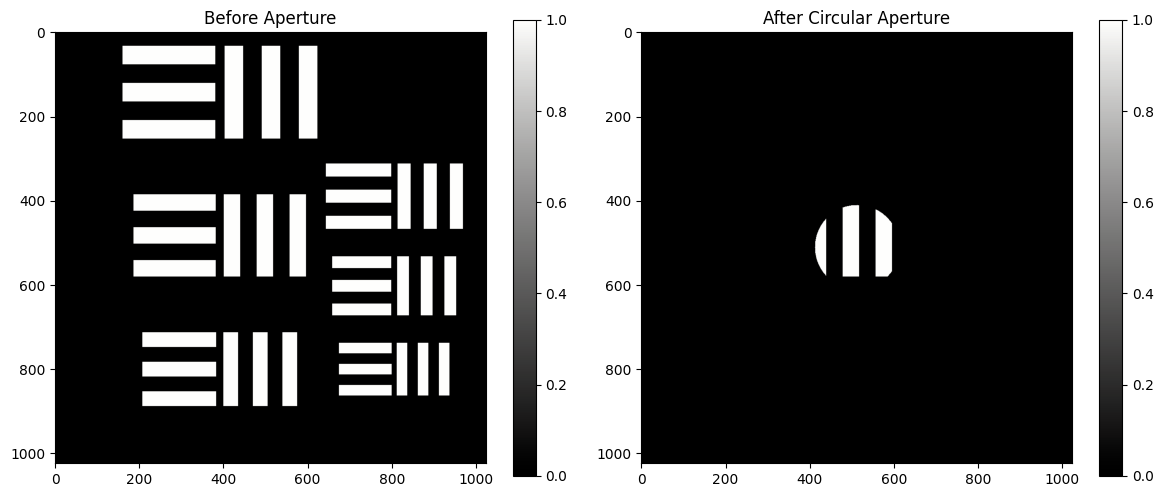

In [27]:
# Visualize the effect of the aperture
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(zoomed_wave.field)**2, cmap=cmo.gray)
axes[0].set_title('Before Aperture')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(after_aperture.field)**2, cmap=cmo.gray)
axes[1].set_title('After Circular Aperture')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 6. Fraunhofer Propagation - To Camera Plane

The `fraunhofer_prop` function models far-field (Fraunhofer) diffraction, which is appropriate for propagation from the aperture plane to the camera when the propagation distance is large.

In [28]:
# Propagate to camera plane
travel_distance = 0.1  # 100 mm to camera

at_camera = jns.prop.fraunhofer_prop(after_aperture, travel_distance)

print(f"Propagation distance: {travel_distance * 1e3:.0f} mm")
print(f"Camera plane dx: {at_camera.dx * 1e6:.2f} microns")

Propagation distance: 100 mm
Camera plane dx: 12.36 microns


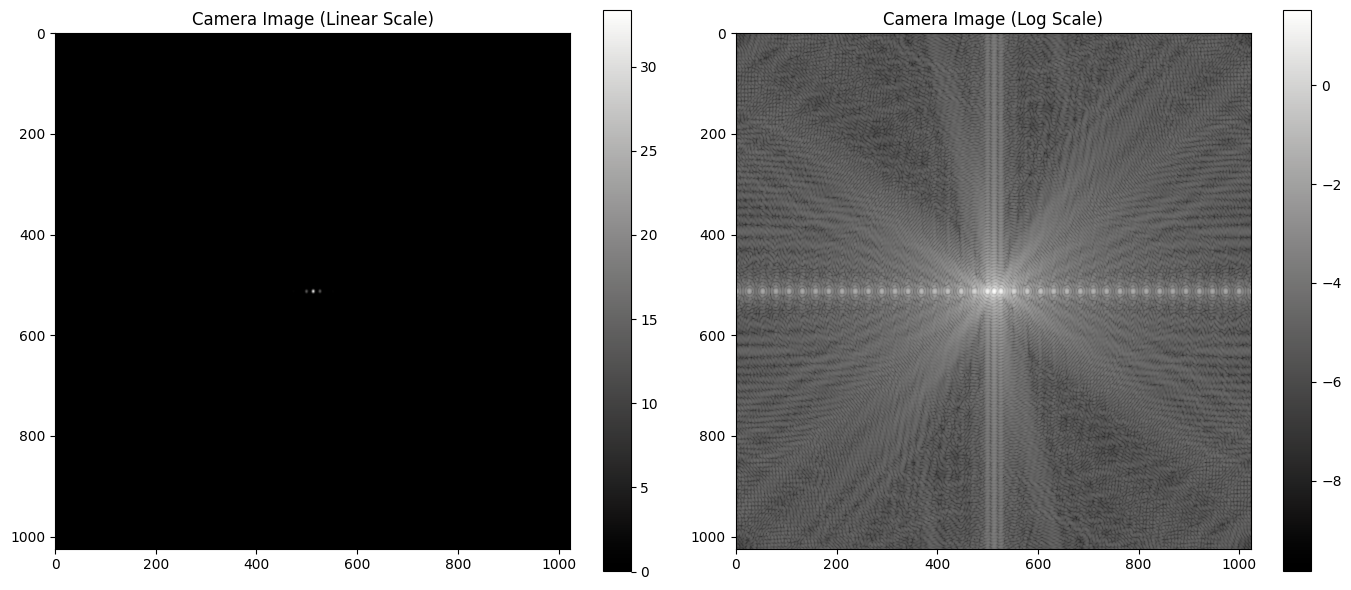

In [29]:
# Calculate the camera image intensity
camera_intensity = jns.optics.field_intensity(at_camera.field)

# Visualize the camera image
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(camera_intensity, cmap=cmo.gray)
axes[0].set_title('Camera Image (Linear Scale)')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.log10(camera_intensity + 1e-10), cmap=cmo.gray)
axes[1].set_title('Camera Image (Log Scale)')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 7. Complete Pipeline Comparison

Let's compare using the individual steps versus the built-in `simple_diffractogram` function.

In [19]:
# Using diffractogram_noscale (combines all steps without camera pixel scaling)
# Note: simple_diffractogram includes camera pixel scaling which has JAX tracing issues
# with jax.image.resize. Use diffractogram_noscale for the wavefront at camera plane.

at_camera_combined = jns.scopes.diffractogram_noscale(
    sample_cut=sample_region,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
)

# Calculate intensity manually
diffractogram_intensity = jns.optics.field_intensity(at_camera_combined.field)

print(f"Diffractogram shape: {diffractogram_intensity.shape}")
print(f"Diffractogram dx: {at_camera_combined.dx * 1e6:.2f} microns")

Diffractogram shape: (1024, 1024)
Diffractogram dx: 12.36 microns


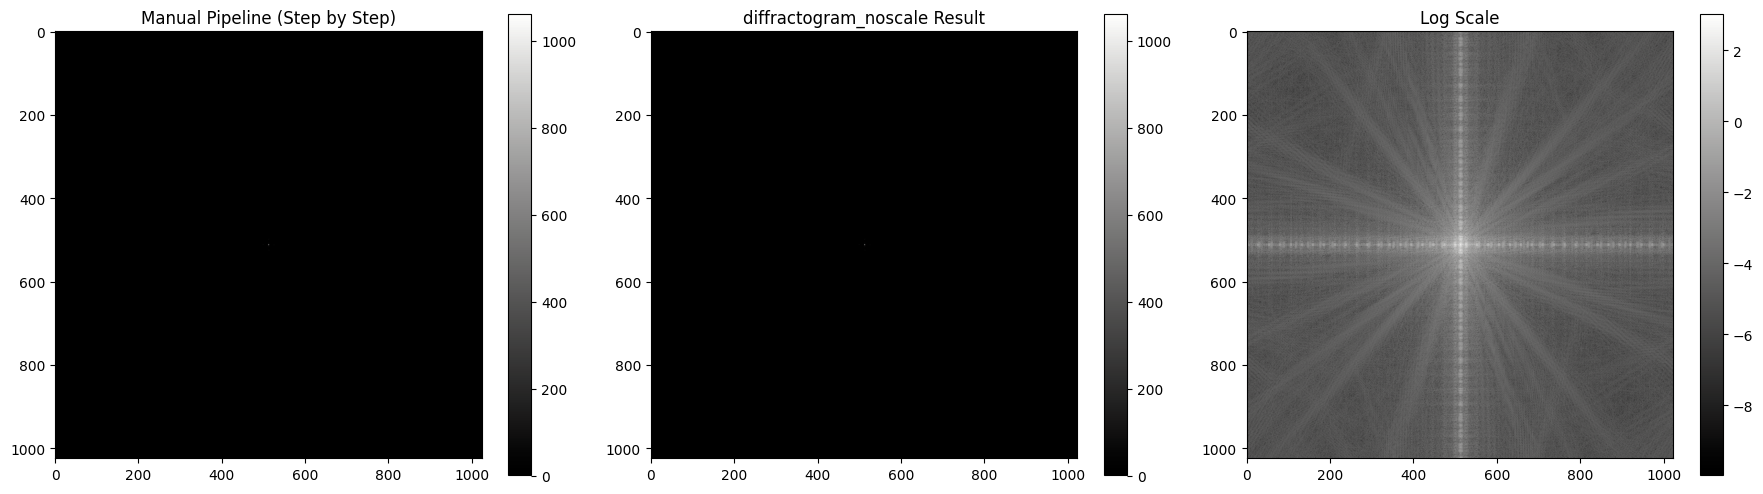

Max difference: 0.00e+00


In [20]:
# Visualize the diffractogram and compare with manual steps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Manual pipeline result
im0 = axes[0].imshow(camera_intensity, cmap=cmo.gray)
axes[0].set_title('Manual Pipeline (Step by Step)')
plt.colorbar(im0, ax=axes[0])

# Combined function result
im1 = axes[1].imshow(diffractogram_intensity, cmap=cmo.gray)
axes[1].set_title('diffractogram_noscale Result')
plt.colorbar(im1, ax=axes[1])

# Log scale comparison
im2 = axes[2].imshow(jnp.log10(diffractogram_intensity + 1e-10), cmap=cmo.gray)
axes[2].set_title('Log Scale')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# Verify they match
print(f"Max difference: {jnp.max(jnp.abs(camera_intensity - diffractogram_intensity)):.2e}")

## 8. Full Microscope Simulation - Multiple Positions

The `simple_microscope` function calculates diffractograms at multiple sample positions in parallel using JAX's `vmap`. This is useful for ptychography or scanning microscopy.

**Note:** Due to JAX tracing limitations with `jax.image.resize`, we'll demonstrate manual position scanning using `diffractogram_noscale`.

In [21]:
scan_step = 50e-6  # 50 micron step size
center_position = sample_size / 2

positions_1d = jnp.array([-1, 0, 1]) * scan_step + center_position
pos_x, pos_y = jnp.meshgrid(positions_1d, positions_1d)
positions = jnp.stack([pos_x.ravel(), pos_y.ravel()], axis=1)

print(f"Number of scan positions: {len(positions)}")
print(f"Scan positions (microns):")
print(positions * 1e6)

Number of scan positions: 9
Scan positions (microns):
[[ 974.  974.]
 [1024.  974.]
 [1074.  974.]
 [ 974. 1024.]
 [1024. 1024.]
 [1074. 1024.]
 [ 974. 1074.]
 [1024. 1074.]
 [1074. 1074.]]


In [22]:
def compute_diffractogram_at_position(position):
    """Compute a diffractogram at a given sample position."""
    pixel_pos = position / pixel_size
    start_y = jnp.floor(pixel_pos[1] - illumination_size / 2).astype(int)
    start_x = jnp.floor(pixel_pos[0] - illumination_size / 2).astype(int)
    sample_cut = jax.lax.dynamic_slice(
        usaf_sample.sample,
        (start_y, start_x),
        (illumination_size, illumination_size)
    )
    this_sample = jns.utils.make_sample_function(sample=sample_cut, dx=pixel_size)
    at_camera = jns.scopes.diffractogram_noscale(
        sample_cut=this_sample,
        lightwave=lightwave,
        zoom_factor=zoom_factor,
        aperture_diameter=aperture_diameter,
        travel_distance=travel_distance,
    )
    return jns.optics.field_intensity(at_camera.field)

compute_all_diffractograms = jax.vmap(compute_diffractogram_at_position)
diffractogram_images = compute_all_diffractograms(positions)

print(f"Microscope data image shape: {diffractogram_images.shape}")
print(f"Number of diffractograms: {diffractogram_images.shape[0]}")

Microscope data image shape: (9, 1024, 1024)
Number of diffractograms: 9


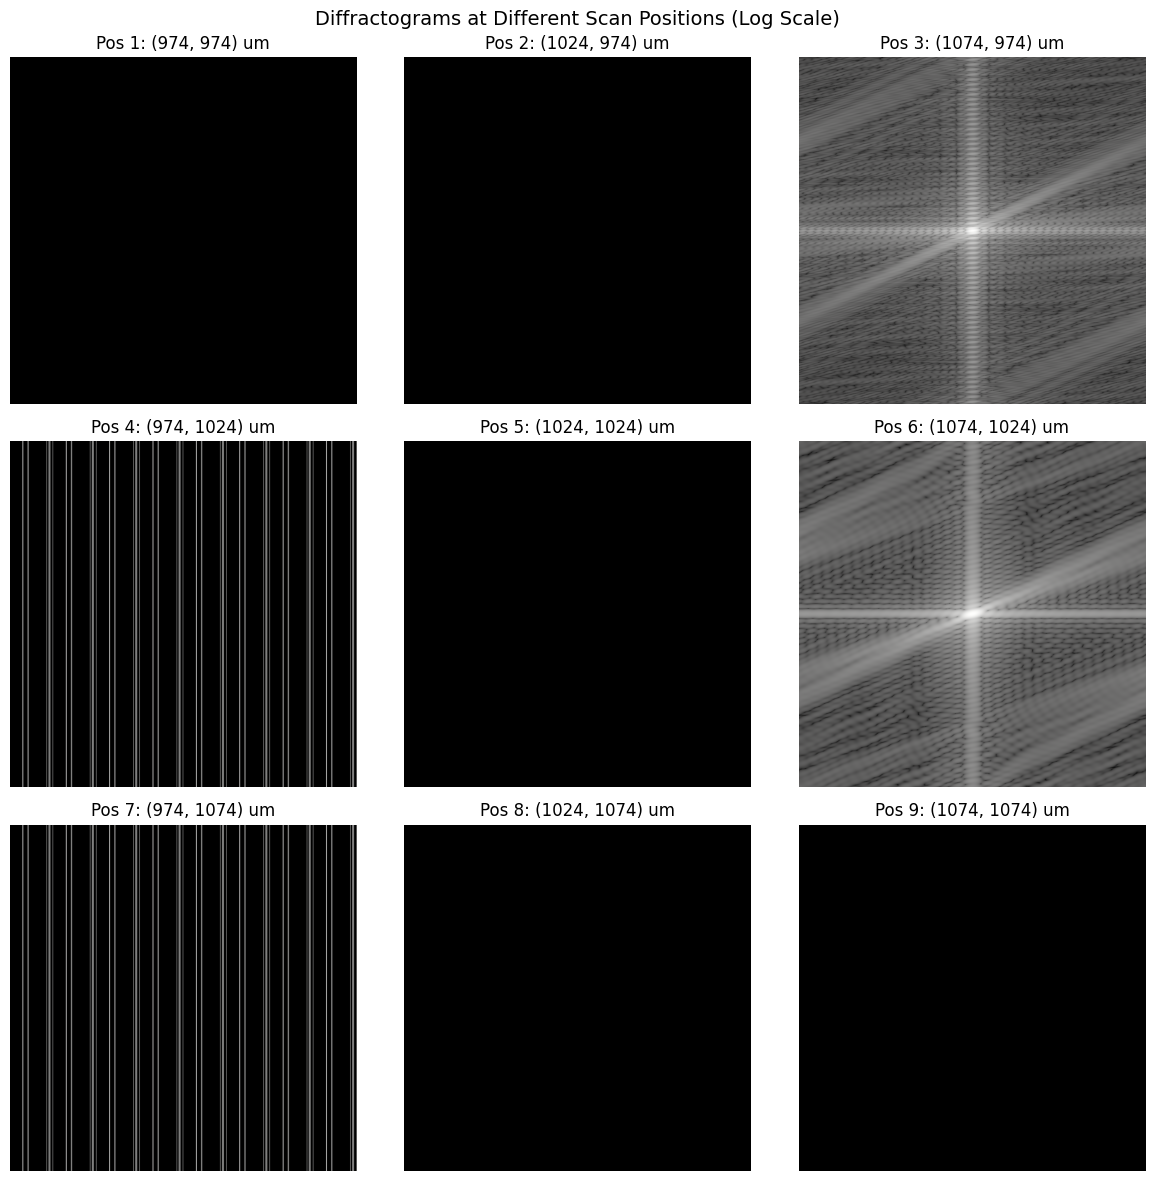

In [23]:
# Visualize all diffractograms from the scan
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(jnp.log10(diffractogram_images[i] + 1e-10), cmap=cmo.gray)
    pos = positions[i]
    ax.set_title(f'Pos {i+1}: ({pos[0]*1e6:.0f}, {pos[1]*1e6:.0f}) um')
    ax.axis('off')

plt.suptitle('Diffractograms at Different Scan Positions (Log Scale)', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Effect of Different Parameters

Let's explore how different optical parameters affect the resulting images.

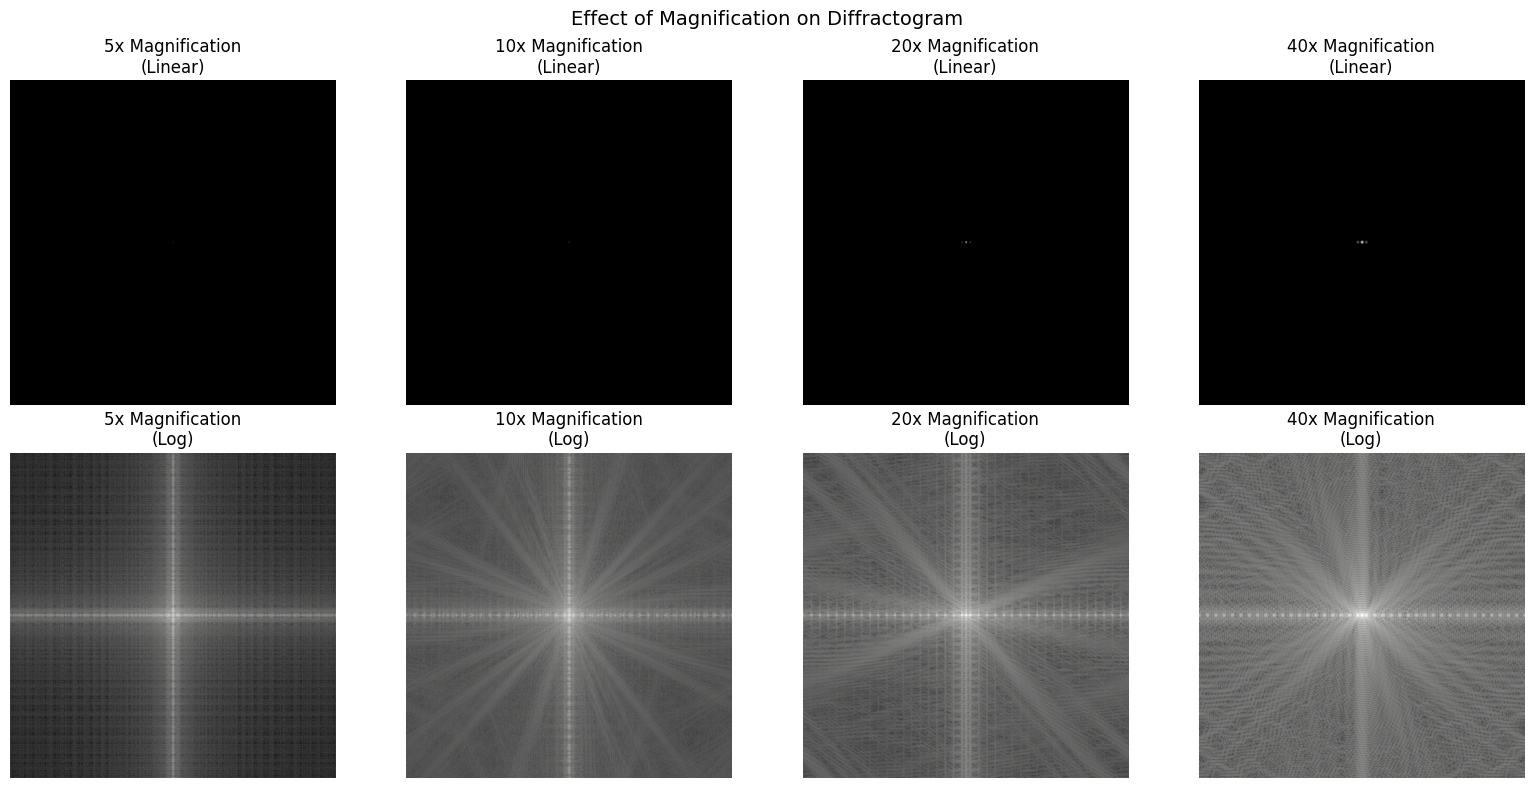

In [24]:
# Compare different zoom factors (magnifications)
zoom_factors = [5.0, 10.0, 20.0, 40.0]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, zf in enumerate(zoom_factors):
    at_camera = jns.scopes.diffractogram_noscale(
        sample_cut=sample_region,
        lightwave=lightwave,
        zoom_factor=zf,
        aperture_diameter=aperture_diameter,
        travel_distance=travel_distance,
    )
    diff_intensity = jns.optics.field_intensity(at_camera.field)
    
    # Linear scale
    axes[0, i].imshow(diff_intensity, cmap=cmo.gray)
    axes[0, i].set_title(f'{zf:.0f}x Magnification\n(Linear)')
    axes[0, i].axis('off')
    
    # Log scale
    axes[1, i].imshow(jnp.log10(diff_intensity + 1e-10), cmap=cmo.gray)
    axes[1, i].set_title(f'{zf:.0f}x Magnification\n(Log)')
    axes[1, i].axis('off')

plt.suptitle('Effect of Magnification on Diffractogram', fontsize=14)
plt.tight_layout()
plt.show()

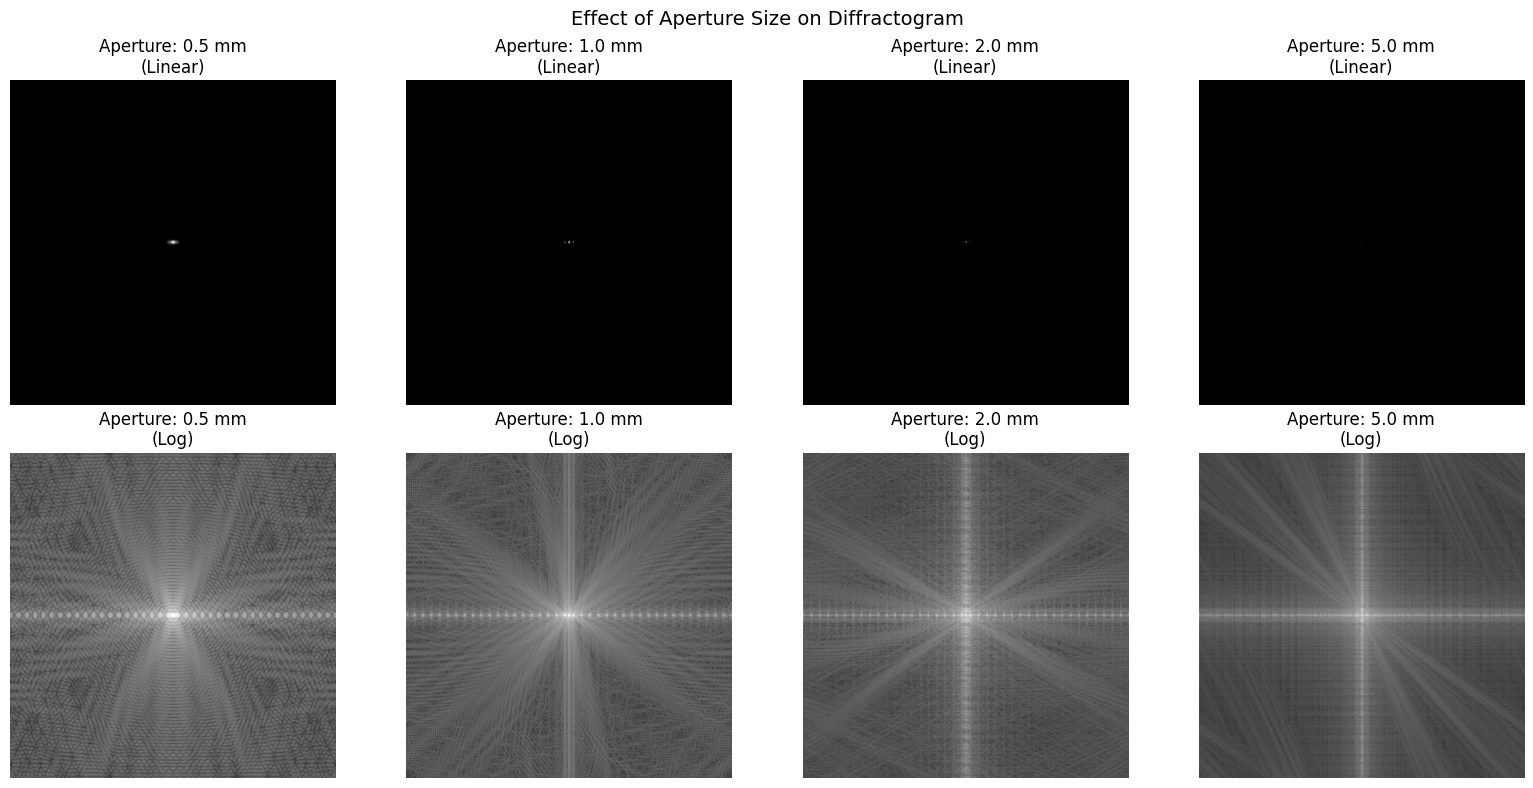

In [25]:
# Compare different aperture sizes (NA)
aperture_diameters = [0.5e-3, 1e-3, 2e-3, 5e-3]  # mm

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, ap in enumerate(aperture_diameters):
    at_camera = jns.scopes.diffractogram_noscale(
        sample_cut=sample_region,
        lightwave=lightwave,
        zoom_factor=zoom_factor,
        aperture_diameter=ap,
        travel_distance=travel_distance,
    )
    diff_intensity = jns.optics.field_intensity(at_camera.field)
    
    # Linear scale
    axes[0, i].imshow(diff_intensity, cmap=cmo.gray)
    axes[0, i].set_title(f'Aperture: {ap*1e3:.1f} mm\n(Linear)')
    axes[0, i].axis('off')
    
    # Log scale
    axes[1, i].imshow(jnp.log10(diff_intensity + 1e-10), cmap=cmo.gray)
    axes[1, i].set_title(f'Aperture: {ap*1e3:.1f} mm\n(Log)')
    axes[1, i].axis('off')

plt.suptitle('Effect of Aperture Size on Diffractogram', fontsize=14)
plt.tight_layout()
plt.show()